# Image processing

## Modules
* openCV (fast)
* scipy.ndimage
* Pillow ("PIL")
* scikit-image (rather slow)
* Mahotas
* simpleITK
* ...

Note: All of these modules use numpy arrays, functions from different modules can be used together!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # OpenCV 3 for advanced image processing
%matplotlib inline

## Color spaces
Images are usually 3-dimensional numpy ndarrays containing the RGB values of each pixel (except when loaded as gray scale images).

<img src="images\colorSpaces.png" style="width: 600px;" align = "left"/> 

## Load and show images

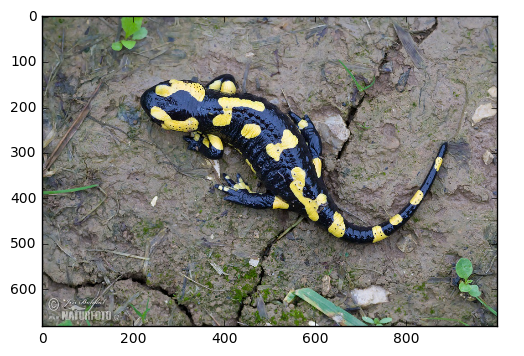

In [19]:
salamander_bgr = cv2.imread('images/fire-salamander2.jpg') # opencv loads images in bgr (blue-green-red) instead rgb
salamander_rgb = cv2.cvtColor(salamander_bgr, cv2.COLOR_BGR2RGB)
salamander_gray = cv2.cvtColor(salamander_bgr, cv2.COLOR_BGR2GRAY)
plt.imshow(salamander_rgb) # opencv has also an imshow function but it does not plot inline

## Image data type

In [23]:
print(type(salamander_rgb))
print('Array entries are of type', salamander_rgb.dtype, '(integers from 0 to 255)')

<class 'numpy.ndarray'>
Array entries are of type uint8 (integers from 0 to 255)


In [24]:
print('RGB image has shape', salamander_rgb.shape)
print('Gray-scale image has shape', salamander_gray.shape, 'and is a 2-dimensional numpy ndarray.')

RGB image has shape (682, 1000, 3)
Gray-scale image has shape (682, 1000) and is a 2-dimensional numpy ndarray.


In [22]:
print(salamander_rgb[:2, :2])

[[[106 107  91]
  [108 109  93]]

 [[108 109  93]
  [108 111  94]]]


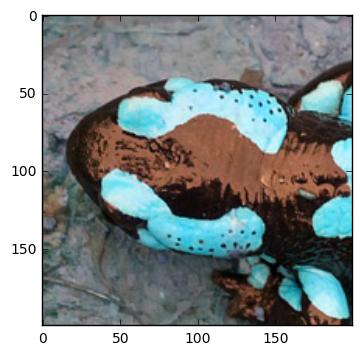

In [21]:
# indexing
plt.imshow(salamander_rgb[100:300, 200:400, [2, 1, 0]]) # image cut-out with red and blue channels switched

## Thresholding and masking
A threshold is used to make the image binary (zeros and ones). For simplicity, the image is loaded in gray-scale and does not contain color information, only brightness values. A colormap has to be defined when plotted.

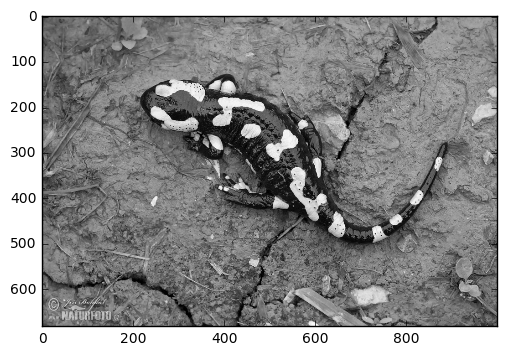

In [18]:
salamander_gray = cv2.imread('images/fire-salamander2.jpg', 0) # load image in gray scale
plt.imshow(salamander_gray, cmap = plt.cm.gray)

(0, 255)

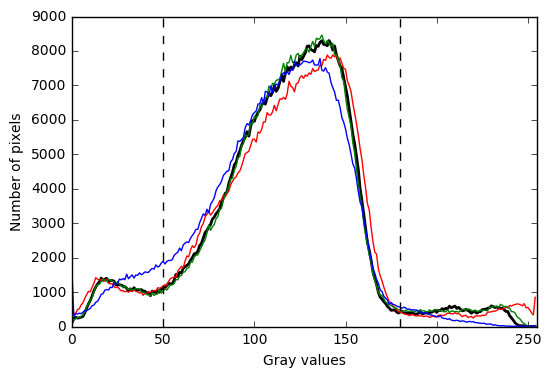

In [73]:
grayPixels, bins = np.histogram(salamander_gray, bins = np.arange(256))
redPixels, bins = np.histogram(salamander_rgb[:, :, 0], bins = np.arange(256))
greenPixels, bins = np.histogram(salamander_rgb[:, :, 1], bins = np.arange(256))
bluePixels, bins = np.histogram(salamander_rgb[:, :, 2], bins = np.arange(256))
plt.plot(grayPixels, 'k', linewidth = 2)
plt.plot(redPixels, 'r')
plt.plot(greenPixels, 'g')
plt.plot(bluePixels, 'b')
lowerThres = 50
upperThres = 180
plt.plot([lowerThres, lowerThres], [0, 9000], '--k') # threshold for dark regions
plt.plot([upperThres, upperThres], [0, 9000], '--k') # threshold for bright regions
plt.xlabel('Gray values')
plt.ylabel('Number of pixels')
plt.xlim(0, 255)

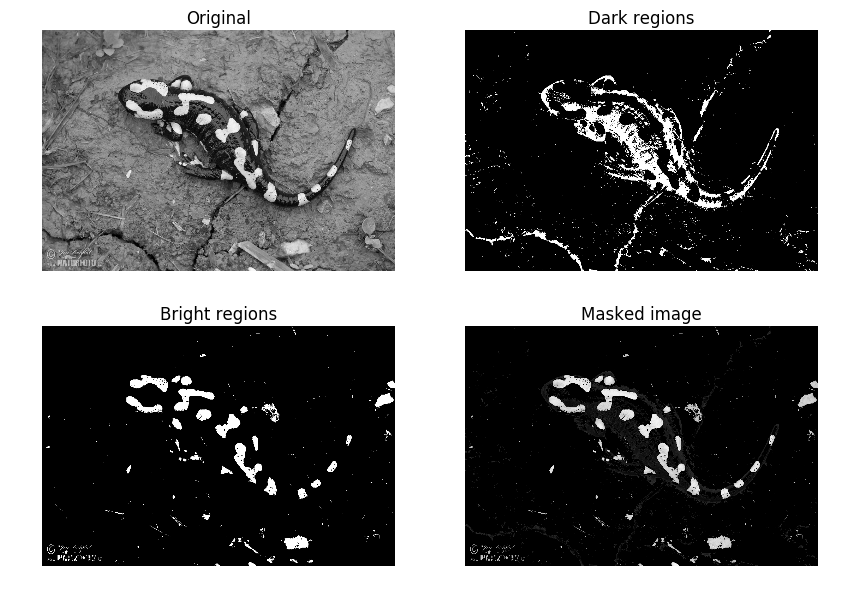

In [74]:
darkRegions = salamander_gray < lowerThres
brightRegions = salamander_gray > upperThres

plt.figure(figsize=(10,7))
plt.subplot(221)
plt.imshow(salamander_gray, cmap = plt.cm.gray)
plt.axis('off')
plt.clim(0, 255)
plt.title('Original')

plt.subplot(222)
plt.imshow(darkRegions, cmap = plt.cm.gray)
plt.axis('off')
plt.title('Dark regions')

plt.subplot(223)
plt.imshow(brightRegions, cmap = plt.cm.gray)
plt.axis('off')
plt.title('Bright regions')

plt.subplot(224)
plt.imshow(salamander_gray*brightRegions+salamander_gray*darkRegions, cmap = plt.cm.gray)
plt.axis('off')
plt.clim(0, 255)
plt.title('Masked image')

## Color filters in Hue-Saturation-Value (HSV)

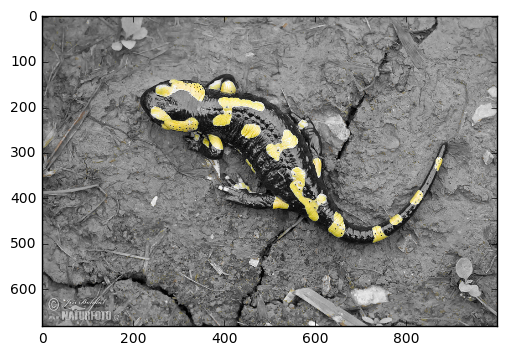

In [153]:
# convert to HSV
salamander_hsv = cv2.cvtColor(salamander_bgr, cv2.COLOR_BGR2HSV)

yellow_lower = np.array([10, 50, 100])
yellow_upper = np.array([30, 255, 255])

# mask yellow regions
yellowMask = cv2.inRange(salamander_hsv, yellow_lower, yellow_upper)

# only yellow regions should be saturated
saturationMask = np.ones(salamander_rgb.shape, dtype = np.uint8)
saturationMask[:, :, 1] = yellowMask > 0

# convert to RGB
salamander_rgb_masked = cv2.cvtColor(salamander_hsv*saturationMask, cv2.COLOR_HSV2RGB)
plt.imshow(salamander_rgb_masked)

## Low-pass and high-pass filter
Filtering by using Fourier transformations

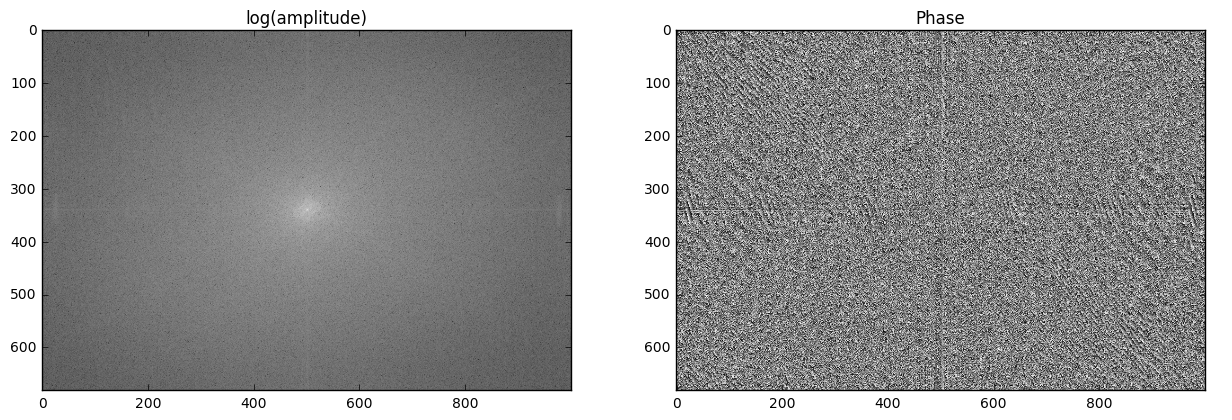

In [56]:
# Fourier transformation
salamander_fft = np.fft.fftshift(np.fft.fft2(salamander_gray))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(np.log(np.abs(salamander_fft)),cmap = plt.cm.gray)
plt.title("log(amplitude)")

plt.subplot(122)
plt.imshow(np.angle(salamander_fft),cmap = plt.cm.gray)
plt.title("Phase")

/home/norma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
/home/norma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log
/home/norma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


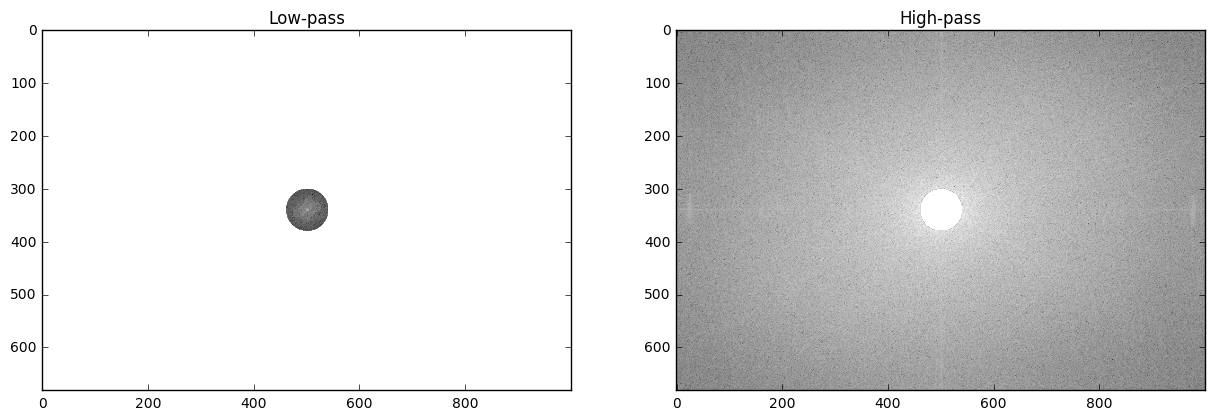

In [61]:
#apply filters
h,w = salamander_gray.shape
radius = 40
lowpass = np.fromfunction(lambda i,j: np.sqrt((i-0.5*h)**2+(j-0.5*w)**2) < radius, salamander_gray.shape)
highpass = - lowpass
salamander_fft_lowpass = np.where(lowpass,salamander_fft,0)
salamander_fft_highpass = np.where(highpass,salamander_fft,0)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.imshow(np.log(np.abs(salamander_fft_lowpass)),cmap = plt.cm.gray)
plt.title("Low-pass")

plt.subplot(122)
plt.imshow(np.log(np.abs(salamander_fft_highpass)),cmap = plt.cm.gray)
plt.title("High-pass")

(4.72083760158e-16-2.74791946527e-30j)


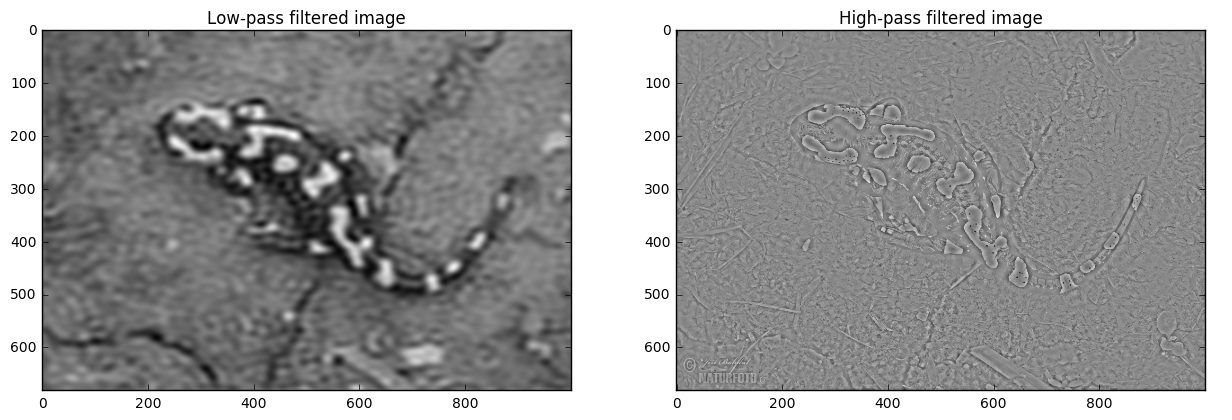

In [62]:
#inverse fourier transformation
salamander_ifft_lowpass = np.fft.ifft2(np.fft.ifftshift(salamander_fft_lowpass))
salamander_ifft_highpass = np.fft.ifft2(np.fft.ifftshift(salamander_fft_highpass))

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.imshow(np.real(salamander_ifft_lowpass), cmap = plt.cm.gray)
plt.title("Low-pass filtered image")
plt.subplot(122)
plt.imshow(np.real(salamander_ifft_highpass), cmap = plt.cm.gray)
plt.title("High-pass filtered image")
print(np.mean(np.ravel(salamander_ifft_highpass)))

## Adaptive thresholding

In [ ]:
# im_gray = cv2.imread('images/EMsectionRodSynapse_labelsRemoved.jpg', 0)
im_gray = cv2.imread('images/billard4.jpg', 0)

## Example: Blob detection